In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import math

In [19]:
from tensorflow import keras
(X_train, y_train) , (X_val, y_val) = keras.datasets.mnist.load_data()

In [26]:
X_train = X_train.reshape(len(X_train),28*28)
X_val = X_val.reshape(len(X_val),28*28)
print(X_val.shape)

(10000, 784)


In [22]:
X_train = X_train/255   # scaling down min-max scalar
X_val = X_val/255

In [48]:
# MyNeuralNetwork(4+2,[784, 256, 128, 64,32, 10],0.01,'relu',128,100)
class NeuralNetwork:
    def __init__(self,N,layer_dim,lr,afunc,batch_size,weight_init,epochs=100):
        self.N = N
        self.layer_dim =layer_dim
        self.lr = lr
        self.afunc = afunc
        self.weight_init = weight_init
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.w = []
        self.b = []
        
# 2 part : Acitivation functions

    def sigmoid(self,y):
        return 1./(1.+np.exp(-y))
    def sigmoid_derivative(self,y):
        return self.sigmoid(y)*(1-self.sigmoid(y))
        
    def tanh(self,y):
        return np.tanh(y)
    def tanh_derivative(self,y):
        return (1. - (np.tanh(y)**2)) 
        
                
    def relu(self,y):
        return np.maximum(0,y)

    def relu_derivative(self,y):
        y[y>0] = 1
        y[y<0] = 0
        return y
        
        
        
    def leakyrelu(self,y):
        return np.where(y > 0, y, y*0.01)
    def leakyrelu_derivative(self,y):
        return np.where(y > 0, 1, 0.01)
    
        
    def linear(self,y):
        return y
    def linear_derivative(self,y):
        return np.ones(y.shape)
    
        
    def softmax(self,arr):
        e_z = np.exp(arr)
        return  ( e_z / np.sum(e_z,axis=0,keepdims=True) )
    
    def softmax_derivative(self,arr):
        return self.softmax(arr)*(1. - self.softmax(arr))     
    
# 3 part : Weight Initializations
    
    def zero_init(self,r,c):
        w = np.zeros((r,c))
        return w
    def random_init(self,r,c):
        scaling_factor = 0.01
        w = np.random.rand(r,c)*scaling_factor
        return w
    def normal_init(self,r,c):
        scaling_factor = 0.001
        w = np.random.normal(size = (r,c),scale=0.01) 
        return w
        
    def apply_activation(self,afunc,y):
        if(afunc == 'sigmoid'):
            return self.sigmoid(y)
        if(afunc == 'tanh'):
            return self.tanh(y)
        if(afunc == 'relu'):
            return self.relu(y)
        if(afunc == 'leakyrelu'):
            return self.leakyrelu(y)
        if(afunc == 'linear'):
            return self.linear(y)
        if(afunc == 'softmax'):
            return self.softmax(y)
        
    def encoding(self,y):
        label = np.zeros((len(y),10))
        for i in range(len(y)):
            label[i][y[i]] = 1
        return label
        
        
    def forward_propagation(self,X,N,afunction):
        activated_output = []
        output = []
        
        inputt = X
        for i in range(0,len(self.w)-1):
            z = np.dot(inputt,self.w[i])+self.b[i]

            activated_z = self.apply_activation(afunction,z)
        
            output.append(z)
            activated_output.append(activated_z)
            
            inputt = activated_z
            
        # softmax on last  layer
        z = np.dot(inputt,self.w[-1])+self.b[-1]
        activated_z = self.softmax(z)
        
        output.append(z)
        activated_output.append(activated_z)  
        
        return output,activated_output
        
    
    def weight_intialize(self,weight_init_type):
        dim = self.layer_dim 
        
        if(weight_init_type == 'zero'):
            for i in range(1,len(dim)):
                inputt_dim = dim[i-1]
                number_of_neurons = dim[i]
                self.w.append(np.array(self.zero_init(inputt_dim,number_of_neurons)))
                self.b.append( np.zeros((1,number_of_neurons)) )
        if(weight_init_type == 'random'):
            for i in range(1,len(dim)):
                inputt_dim = dim[i-1]
                number_of_neurons = dim[i]
                self.w.append(np.array(self.random_init(inputt_dim,number_of_neurons)))
                self.b.append( np.zeros((1,number_of_neurons)) )
        if(weight_init_type == 'normal'):
            for i in range(1,len(dim)):
                inputt_dim = dim[i-1]
                number_of_neurons = dim[i]
                self.w.append(np.array(self.normal_init(inputt_dim,number_of_neurons)))
                self.b.append( np.zeros((1,number_of_neurons)) )
            
        return self.w,self.b
    
    def loss(self,y_true,y_pred):
        return np.sum( - ( np.log( y_pred[np.arange(len(y_true)),y_true.argmax(axis=1) ]+1e-9) ) )/ len(y_true)
      
        
    def apply_derivative(self,afunc,y):
        if(afunc == 'sigmoid'):
            return self.sigmoid_derivative(y)
        if(afunc == 'tanh'):
            return self.tanh_derivative(y)
        if(afunc == 'relu'):
            return self.relu_derivative(y)
        if(afunc == 'leakyrelu'):
            return self.leakyrelu_derivative(y)
        if(afunc == 'linear'):
            return self.linear_derivative(y)
        if(afunc == 'softmax'):
            return self.softmax(y)
        

    def back_propagation(self,X,y,output,activated_output):
        dz_last = (activated_output[-1] - y)
    
        dw_last = (np.dot(activated_output[-1-1].T,dz_last))/len(X)
        db_last = (np.sum(dz_last,axis=0,keepdims=True))/len(X)
        
        self.w[-1],self.b[-1] = self.Gradient(self.w[-1],self.b[-1],dw_last,db_last,self.lr) 
       
        mul_str = np.dot(dz_last,self.w[-1].T)
#         print("mul_str shape",mul_str.shape)
 
        for i in range(len(activated_output)-2,-1,-1):
        
            dz = self.apply_derivative(self.afunc,output[i]) * mul_str
            if(i > 0):
                mul_str = np.dot(dz,self.w[i].T)
            if(i!=0):
                dw = (np.dot(activated_output[i-1].T,dz))/len(X)
                db = (np.sum(dz,axis=0,keepdims=True))/len(X)
            if(i==0):
                dw = (np.dot(X.T,dz))/len(X)
                db = (np.sum(dz,axis=0,keepdims=True))/len(X)
#             print("dw and w shape",dw.shape,self.w[i].shape)
            self.w[i],self.b[i] = self.Gradient(self.w[i],self.b[i],dw,db,self.lr) 
#             print(self.w[i],self.b[i])

        return self.w,self.b
        
    def Gradient(self,w,b,dw,db,lr):
        # update weights
        w = w - self.lr * dw
        b = b - self.lr * db
        return w,b
        
        
        
    def fit(self,X_train,y_train,X_val,y_val):
        # initialize weights
        self.w,self.b = self.weight_intialize(self.weight_init)
        y_train = self.encoding(y_train)
#         y_val = self.encoding(y_val)
        
        
        val_loss =   []
        train_loss = []
        
        X_batch = []
        y_batch = []
        
        number_of_batch = int(len(X_train)/self.batch_size)
        for j in range(number_of_batch):
                X_batch.append(X_train[j*self.batch_size:(j+1)*(self.batch_size),:])
                y_batch.append(y_train[j*self.batch_size:(j+1)*(self.batch_size),:]) # NEED TO CHECK Y dim        
        
        print("Number of batches ",number_of_batch)
        
        
        for i in range(1,1+self.epochs):
            
            # do batch wise forward propagation
            batch_loss = 0
            batch_val_loss = 0
            
            for k in range(len(X_batch)):
                # Forward Prop
                unactivated_outputs,activated_output = self.forward_propagation(X_batch[k],self.N,self.afunc)
                # Calculate Loss
                loss = self.loss(y_batch[k],activated_output[-1])
                loss_val = self.loss(self.encoding(y_val),(self.predict_proba(X_val)))
                
                if(math.isnan(loss)):
                    loss = 0
                batch_loss += loss     
                batch_val_loss += loss_val
                # Back prop
                self.w,self.b = self.back_propagation(X_batch[k],y_batch[k],unactivated_outputs,activated_output)
#                 print(self.w)
        
            train_loss.append((batch_loss)/len(X_batch))
            val_loss.append(batch_val_loss/len(X_val))
            
            if(i%10 == 0):
                print("Epoch :",i," Training Loss:",train_loss[-1]," Validation Loss:",val_loss[-1])
                
        import seaborn as sns
        sns.lineplot(x=np.arange(1,1+self.epochs),y=train_loss,label='Training Loss')
        plt.figure()
        sns.lineplot(x=np.arange(1,1+self.epochs),y=val_loss,label='Validation Loss')

    def predict(self,X):
        y_class = self.predict_proba(X)
        return y_class.argmax(axis = 1)
    def predict_proba(self,X):
        unactivated_outputs,activated_output = self.forward_propagation(X,self.N,self.afunc)
        return activated_output[-1]
    def score(self,X,y):
        y_pred = self.predict(X)
        accuracy = np.sum(y_pred == y)/len(y)
        print(accuracy)
    
# model = NeuralNetwork(4+2,[784, 256, 128, 64,32, 10],1e-5,'relu',128,'normal',100)  
# model.fit(X_train,y_train,X_val,y_val)

In [45]:
print(model.score(X_val,y_val))

0.0628
None


Relu

Number of batches  468
Epoch : 10  Training Loss: 4.8518052540209196  Validation Loss: 0.43103298195929984
Epoch : 20  Training Loss: 4.8516973736699605  Validation Loss: 0.431027960129129
Epoch : 30  Training Loss: 4.851580911811103  Validation Loss: 0.4310225468807921
Epoch : 40  Training Loss: 4.851454295986609  Validation Loss: 0.4310166717353817
Epoch : 50  Training Loss: 4.851315769539674  Validation Loss: 0.4310102567140005


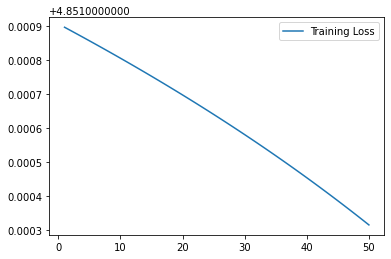

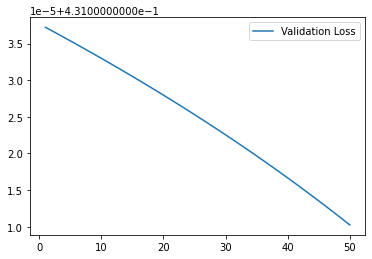

In [49]:
model = NeuralNetwork(4+2,[784, 256, 128, 64,32, 10],1e-5,'relu',128,'random',50)
model.fit(X_train,y_train,X_val,y_val)

In [50]:
print(model.score(X_val,y_val))

0.1929
None


Sigmoid

Number of batches  468
Epoch : 10  Training Loss: 4.852030135534621  Validation Loss: 3.232829003490293
Epoch : 20  Training Loss: 4.85203013553462  Validation Loss: 3.232829003490293
Epoch : 30  Training Loss: 4.852030135534621  Validation Loss: 3.232829003490293
Epoch : 40  Training Loss: 4.852030135534621  Validation Loss: 3.232829003490293
Epoch : 50  Training Loss: 4.852030135534623  Validation Loss: 3.232829003490293


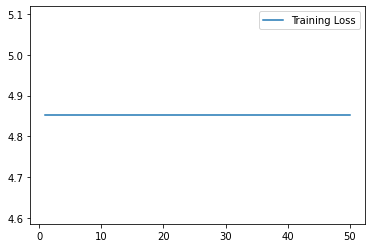

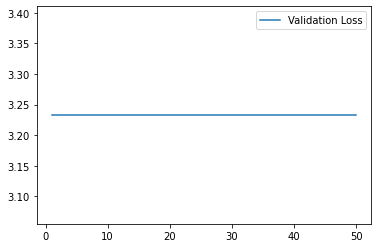

In [68]:
model = NeuralNetwork(4+2,[784, 256, 128, 64,32, 10],1e-10,'sigmoid',128,'normal',50)
model.fit(X_train,y_train,X_val,y_val)

In [54]:
print(model.score(X_val,y_val))

0.0509
None


tanh


Number of batches  468
Epoch : 10  Training Loss: 4.852020640245333  Validation Loss: 3.2328140301937727
Epoch : 20  Training Loss: 4.85202064003861  Validation Loss: 3.232814030092805
Epoch : 30  Training Loss: 4.852020639831894  Validation Loss: 3.2328140299918338
Epoch : 40  Training Loss: 4.852020639625166  Validation Loss: 3.2328140298908603
Epoch : 50  Training Loss: 4.852020639418443  Validation Loss: 3.2328140297898877


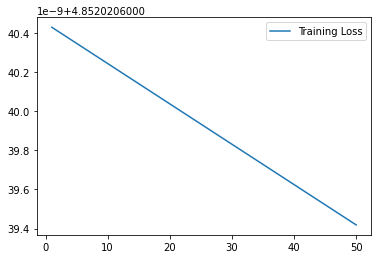

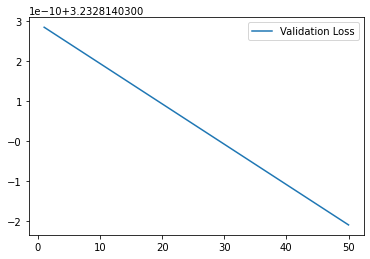

In [57]:
model = NeuralNetwork(4+2,[784, 256, 128, 64,32, 10],1e-10,'tanh',128,'random',50)
model.fit(X_train,y_train,X_val,y_val)

In [58]:
print(model.score(X_val,y_val))

0.1135
None


Leaky ReLu

Number of batches  468
Epoch : 10  Training Loss: 4.851861136709395  Validation Loss: 3.2327524636685427
Epoch : 20  Training Loss: 4.851763216987901  Validation Loss: 3.2327107158812955
Epoch : 30  Training Loss: 4.85165775073459  Validation Loss: 3.232665790186646
Epoch : 40  Training Loss: 4.851543346885774  Validation Loss: 3.232617107899124
Epoch : 50  Training Loss: 4.8514184506369915  Validation Loss: 3.232564025542196
0.1774
None


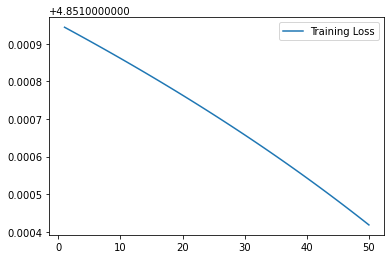

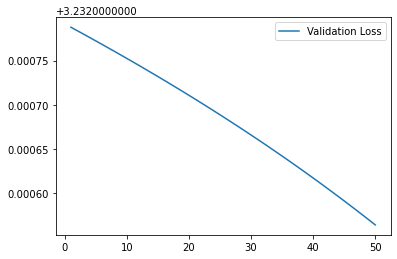

In [60]:
model = NeuralNetwork(4+2,[784, 256, 128, 64,32, 10],1e-5,'leakyrelu',128,'random',50)
model.fit(X_train,y_train,X_val,y_val)
print(model.score(X_val,y_val))

Identtiy

Number of batches  468
Epoch : 10  Training Loss: 4.851998943810024  Validation Loss: 3.23284016451554
Epoch : 20  Training Loss: 4.85199894294795  Validation Loss: 3.2328401641553697
Epoch : 30  Training Loss: 4.8519989420858725  Validation Loss: 3.2328401637952036
Epoch : 40  Training Loss: 4.851998941223803  Validation Loss: 3.232840163435035
Epoch : 50  Training Loss: 4.851998940361729  Validation Loss: 3.2328401630748647
Epoch : 60  Training Loss: 4.851998939499658  Validation Loss: 3.232840162714694
Epoch : 70  Training Loss: 4.851998938637579  Validation Loss: 3.2328401623545275
Epoch : 80  Training Loss: 4.8519989377755035  Validation Loss: 3.232840161994357
Epoch : 90  Training Loss: 4.851998936913429  Validation Loss: 3.232840161634186
Epoch : 100  Training Loss: 4.851998936051353  Validation Loss: 3.2328401612740194
0.0896
None


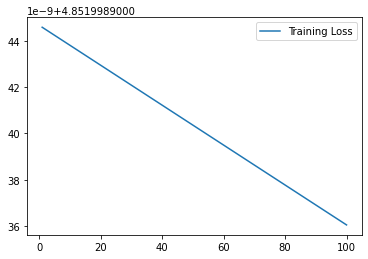

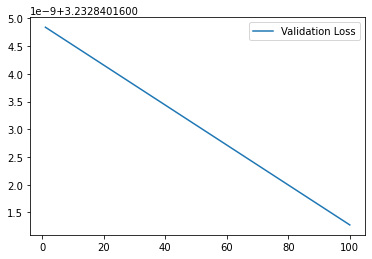

In [71]:
model = NeuralNetwork(4+2,[784, 256, 128, 64,32, 10],1e-10,'linear',128,'random',100)
model.fit(X_train,y_train,X_val[:1000],y_val[:1000])
print(model.score(X_val,y_val))